In [17]:
!pip install lion-pytorch

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [18]:
import torch
import random
import numpy as np
import torchvision.datasets
import matplotlib.pyplot as plt
from itertools import product
from torch import tensor
import pickle
import time
from lion_pytorch import Lion

In [19]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [20]:
MNIST_train = torchvision.datasets.MNIST('./', train=True, download=True)
MNIST_test = torchvision.datasets.MNIST('./', train=False, download=True)
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [21]:
X_val = X_train[-5000:]
y_val = y_train[-5000:]

X_train = X_train[:-5000]
y_train = y_train[:-5000]

In [22]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [23]:
resume = True

if resume: 
    with open('lion_small_big_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_lion = arr["acc"]
        test_loss_history_lion = arr["loss"]
        loss_in_training_lion = arr["loss_train"]
        time_learning_lion = arr["time"]
else:
    test_accuracy_history_lion, test_loss_history_lion, loss_in_training_lion, time_learning_lion = {}, {}, {}, {}

In [8]:
test_accuracy_history_lion

{(0.01, 0.001): [tensor(0.6810),
  tensor(0.5614),
  tensor(0.6100),
  tensor(0.3762),
  tensor(0.3696),
  tensor(0.4024),
  tensor(0.3540),
  tensor(0.3360),
  tensor(0.4102),
  tensor(0.2460),
  tensor(0.1792),
  tensor(0.0998),
  tensor(0.1126),
  tensor(0.0966),
  tensor(0.0964),
  tensor(0.0916),
  tensor(0.1126),
  tensor(0.1126),
  tensor(0.0998),
  tensor(0.1126)],
 (0.01, 0.0003): [tensor(0.7312),
  tensor(0.5992),
  tensor(0.4796),
  tensor(0.4204),
  tensor(0.3446),
  tensor(0.2850),
  tensor(0.3250),
  tensor(0.2814),
  tensor(0.2846),
  tensor(0.2818),
  tensor(0.2930),
  tensor(0.2794),
  tensor(0.2830),
  tensor(0.3014),
  tensor(0.3172),
  tensor(0.3190),
  tensor(0.3330),
  tensor(0.3518),
  tensor(0.3890),
  tensor(0.3344)],
 (0.01, 0.0001): [tensor(0.7198),
  tensor(0.3884),
  tensor(0.3258),
  tensor(0.1916),
  tensor(0.0966),
  tensor(0.0916),
  tensor(0.0978),
  tensor(0.0978),
  tensor(0.0986),
  tensor(0.0916),
  tensor(0.0988),
  tensor(0.1126),
  tensor(0.1060

In [9]:
for learning_rate, weight_decay in product([0.01, 0.001, 0.0001, 0.00005], [0, 1e-3, 3e-4, 1e-4]):
    
    key = (learning_rate, weight_decay)
    if key in test_accuracy_history_lion:
        print("Already computed, ignoring")
        continue
    
    lenet5 = LeNet5()
    loss = torch.nn.CrossEntropyLoss()
    optimizer = Lion(lenet5.parameters(), lr=learning_rate, weight_decay=weight_decay)
    batch_size = 100
    
    test_loss_history_lion[key] = list()
    test_accuracy_history_lion[key] = list()
    loss_in_training_lion[key] = list()
    time_learning_lion[key] = list()

    for epoch in range(20):
        order = np.random.permutation(len(X_train))
        
        start_time = time.time()
        
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
        
            batch_indexes = order[start_index:start_index+batch_size]
        
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
        
            preds = lenet5.forward(X_batch) 
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()
        
        time_learning_lion[key].append(time.time() - start_time)
        loss_in_training_lion[key].append(float(loss(lenet5.forward(X_train), y_train)))
        print(loss_in_training_lion[key])
        
        test_preds = lenet5.forward(X_val)
        test_loss_history_lion[key].append(loss(test_preds, y_val).data)
    
        accuracy = (test_preds.argmax(dim=1) == y_val).float().mean().data
        test_accuracy_history_lion[key].append(accuracy)
        print(accuracy)
    
    print(test_accuracy_history_lion[(learning_rate, weight_decay)])
    print(loss_in_training_lion[(learning_rate, weight_decay)])
    with open('lion_small_big_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_lion, "loss": test_loss_history_lion, "loss_train":loss_in_training_lion, "time":time_learning_lion}, f)

Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring


In [10]:
colors = ['r', 'b', 'g', 'k', 'm', 'c', 'y', 'orange', 'teal', 'cyan', 'purple', 'deeppink']

In [11]:
del test_accuracy_history_lion[(0.01, 1e-3)]
del test_accuracy_history_lion[(0.01, 3e-4)]
del test_accuracy_history_lion[(0.01, 1e-4)]
del test_accuracy_history_lion[(0.01, 0)]

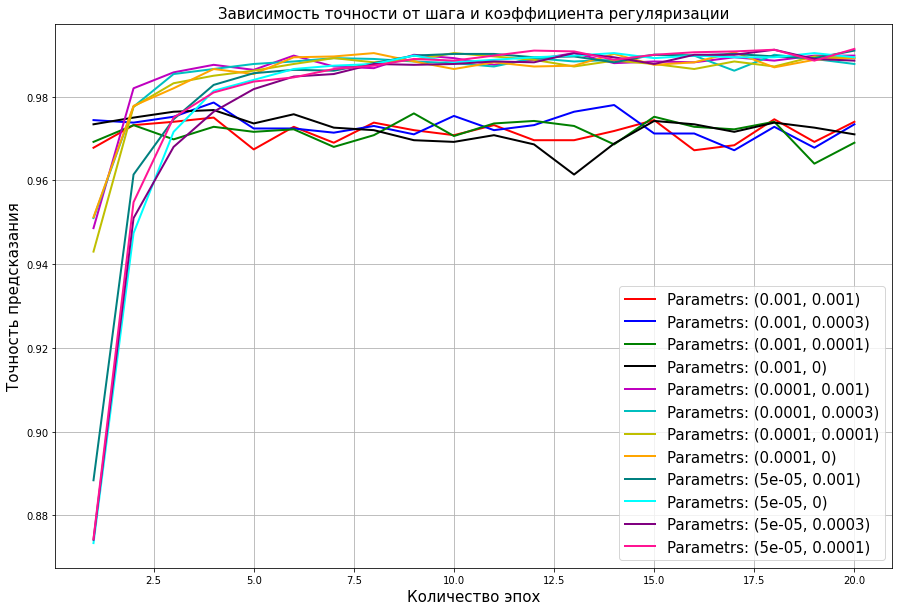

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_lion.items():
    plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)

In [13]:
del test_loss_history_lion[(0.01, 1e-3)]
del test_loss_history_lion[(0.01, 3e-4)]
del test_loss_history_lion[(0.01, 1e-4)]
del test_loss_history_lion[(0.01, 0)]

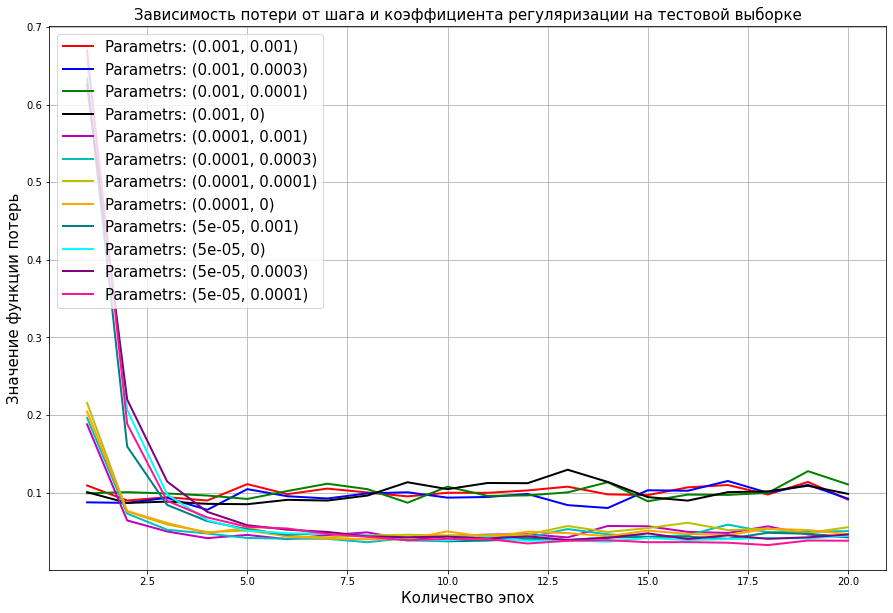

In [14]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in test_loss_history_lion.items():
    plt.plot(range(1, 21), list(map(lambda x: x.item(), loss)), label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15, loc='upper left')
plt.grid(True)

In [15]:
del loss_in_training_lion[(0.01, 1e-3)]
del loss_in_training_lion[(0.01, 3e-4)]
del loss_in_training_lion[(0.01, 1e-4)]
del loss_in_training_lion[(0.01, 0)]

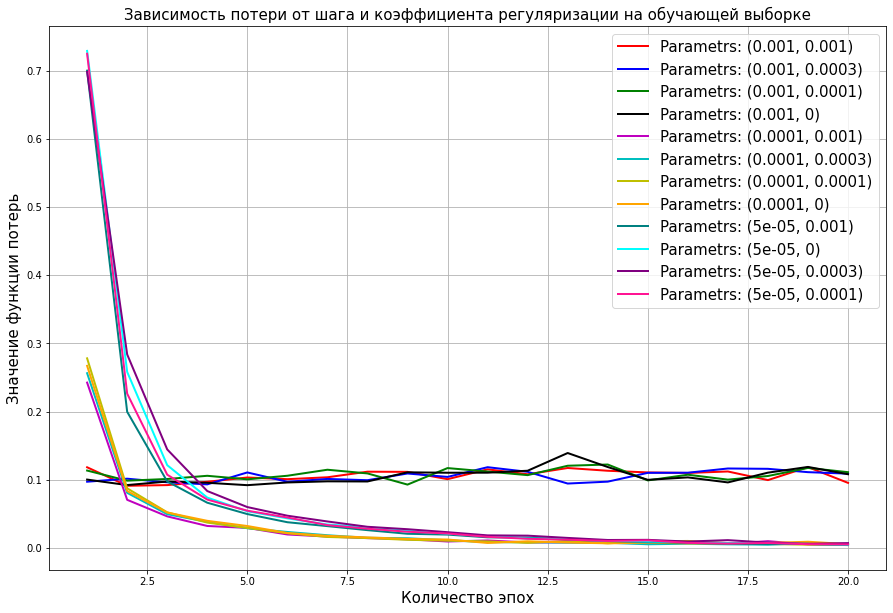

In [16]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in loss_in_training_lion.items():
    plt.plot(range(1, 21), loss, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)

In [24]:
import tqdm

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [25]:
lenet5 = LeNet5()
# lenet5.cuda()
loss = torch.nn.CrossEntropyLoss()
optimizer = Lion(lenet5.parameters(), lr=0.0001, weight_decay=0)
batch_size = 100

test_loss_history_lion = list()
test_accuracy_history_lion = list()
loss_in_training_lion = list()
time_learning_lion = list()

for epoch in tqdm.tqdm(range(20)):

    order = np.random.permutation(len(X_train))
    start_time = time.time()

    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = lenet5.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    time_learning_lion.append(time.time() - start_time)
    loss_in_training_lion.append(float(loss(lenet5.forward(X_train), y_train)))
    
    test_preds = lenet5.forward(X_test)
    test_loss_history_lion.append(loss(test_preds, y_test).data)

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data
    test_accuracy_history_lion.append(accuracy)

with open('lion_mresults.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_lion, "loss": test_loss_history_lion, "loss_train":loss_in_training_lion, "time":time_learning_lion}, f)

100%|██████████| 20/20 [02:19<00:00,  6.97s/it]


In [26]:
test_accuracy_history_lion

[tensor(0.9286),
 tensor(0.9733),
 tensor(0.9824),
 tensor(0.9865),
 tensor(0.9879),
 tensor(0.9890),
 tensor(0.9878),
 tensor(0.9874),
 tensor(0.9894),
 tensor(0.9869),
 tensor(0.9877),
 tensor(0.9891),
 tensor(0.9887),
 tensor(0.9890),
 tensor(0.9886),
 tensor(0.9874),
 tensor(0.9895),
 tensor(0.9893),
 tensor(0.9895),
 tensor(0.9891)]

In [27]:
import tqdm

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [28]:
lenet5 = LeNet5()
loss = torch.nn.CrossEntropyLoss()
optimizer = Lion(lenet5.parameters(), lr=0.0001, weight_decay=0)
batch_size = 100

test_loss_history_lion = list()
test_accuracy_history_lion = list()
loss_in_training_lion = list()

start_time = time.time()
accuracy = 0

while accuracy <= 0.985:
    order = np.random.permutation(len(X_train))

    for start_index in range(0, len(X_train), batch_size):
        
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = lenet5.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    loss_in_training_lion.append(float(loss(lenet5.forward(X_train), y_train)))
    
    test_preds = lenet5.forward(X_test)
    test_loss_history_lion.append(loss(test_preds, y_test).data)

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data
    test_accuracy_history_lion.append(accuracy)
    
time_learning_lion = time.time() - start_time
with open('lion_mresults_985.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_lion, "loss": test_loss_history_lion, "loss_train":loss_in_training_lion, "time":time_learning_lion}, f)

In [29]:
test_accuracy_history_lion

[tensor(0.9213),
 tensor(0.9736),
 tensor(0.9819),
 tensor(0.9842),
 tensor(0.9852)]